In [4]:
import numpy as np
import matplotlib.pyplot as plt

from random import shuffle, choice

In [55]:
class Lineaire(object):
    def __init__(self, loss, loss_g, max_iter=0, eps=0.01, patience=3):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
        """
        self.max_iter, self.eps = max_iter, eps
        self.loss, self.loss_g = loss, loss_g
        self.patience = patience

    def fit(self, datax, datay, testx=None, testy=None, batch_size=None):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        if batch_size is None:
            batch_size = len(datax)
        datay = datay.reshape(-1,1)
        N = len(datay)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        self.w = np.random.normal(0, .1, size=(1,D))
        train_h, test_h = [], []
        
        if self.max_iter > 0:
            for _ in range(self.max_iter):

                loss = self.loss(datax, datay, self.w)
                loss_g = self.loss_g(datax, datay, self.w)
                self.w = self.w - self.eps * loss_g

                train_h.append(loss)
                test_h.append(self.loss(testx, testy, self.w))
        else:
            keep_learning = 0
            # Faire une première itération
            loss = self.loss(datax, datay, self.w)
            loss_g = self.loss_g(datax, datay, self.w)
            self.w = self.w - self.eps * loss_g

            train_h.append(loss)
            test_h.append(self.loss(testx, testy, self.w))
            
            # On y va
            while keep_learning < self.patience:
                loss = self.loss(datax, datay, self.w)
                loss_g = self.loss_g(datax, datay, self.w)
                self.w = self.w - self.eps * loss_g

                train_h.append(loss)
                test_h.append(self.loss(testx, testy, self.w))
                
                if test_h[-1] >= min(test_h[:-1]):
                    keep_learning += 1
                else:
                    keep_learning = 0
                
        return train_h, test_h

    def predict(self,datax):
        if len(datax.shape)==1:
            datax = datax.reshape(1, -1)
        return self.w.dot(datax.T) > 0

    def score(self,datax,datay):
        return (self.predict(datax) == datay).mean()

In [6]:
def norm_p(X, p):
    if p == 1:
        return sum([abs(x) for x in X.T])
    elif p == np.inf:
        return max([abs(x) for x in X.T])
    else:
        return sum([x ** p for x in X.T]) ** (1/p)
norm1 = lambda X: norm_p(X, 1)
norm2 = lambda X: norm_p(X, 2)

In [7]:
def decorator_vec(fonc):
    def vecfonc(datax, datay, w, *args, **kwargs):
        if not hasattr(datay,"__len__"):
            datay = np.array([datay])
        datax, datay, w = datax.reshape(len(datay),-1), datay.reshape(-1,1), w.reshape((1,-1))
        return fonc(datax, datay, w, *args, **kwargs)
    return vecfonc

In [8]:
@decorator_vec
def mse(datax, datay, w):
    """ retourne la moyenne de l'erreur aux moindres carres """
    y_hat = w.dot(datax.T)
    return ((y_hat - datay)**2).sum()

@decorator_vec
def mse_g(datax, datay, w):
    """ retourne le gradient moyen de l'erreur au moindres carres """
    diff =w.dot(datax.T) - datay
    return np.mean(2 * diff)

def get_tikhonov(alpha):
    # Returns tikhonov function and gradient parametrize by alpha
    def tikhonov(datax, datay, w, alpha):
        return mse(datax, datay, w) + alpha * norm2(w)
    
    return lambda X, Y, W : tikhonov(X, Y, W, alpha)

def get_lasso(alpha):
    # Returns lasso function and gradient parametrize by alpha
    def lasso(datax, datay, w, alpha):
        return mse(datax, datay, w) + alpha * norm1(w)
    
    return lambda X, Y, W : lasso(X, Y, W, alpha)

In [9]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    n = tmp.shape[0]
    tmp[:, 1:] = (tmp[:, 1:] - tmp[:, 1:].min(axis=1).reshape(n, 1)) / tmp[:, 1:].max(axis=1).reshape(n, 1)
    return tmp[:, 1:], tmp[:, 0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def filter_classes(X, Y, y1, y2, balance=True):
    #y1 et y2 peuvent etre des listes
    y1 = list(np.array([y1]).flatten())
    y2 = list(np.array([y2]).flatten())
    yg = y1 + y2
    X, Y = list(zip(*filter(lambda c: c[1] in yg, zip(X, Y))))
    Y = list(map(lambda y: int(y in y1), Y)) #binarise the classes
    if balance:
        data = list(zip(X, Y))
        positives = list(filter(lambda c: c[1], data))
        negatives = list(filter(lambda c: not c[1], data))
        shuffle(positives)
        shuffle(negatives)
        positives = positives[:min(len(positives), len(negatives))]
        negatives = negatives[:len(positives)]
        data = positives + negatives
        shuffle(data)
        X, Y = list(zip(*data))
    return np.array(X), np.array(Y)

In [10]:
x_train, y_train = load_usps("USPS/USPS_train.txt")
x_test,  y_test  = load_usps("USPS/USPS_test.txt")

In [37]:
classes = [0, 1]

Accuracy :  0.29545454545454547


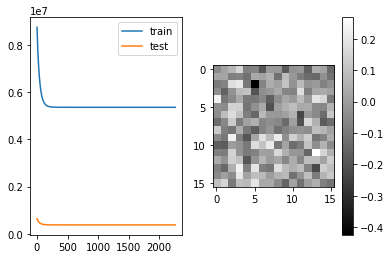

In [56]:
clf = Lineaire(mse, mse_g, eps=.0001, max_iter=0)
tr_x, tr_y = filter_classes(x_train, y_train, classes[0], classes[1])
te_x, te_y = filter_classes(x_test,  y_test,  classes[0], classes[1])
train_h, test_h = clf.fit(tr_x, (tr_y * 2 - 1), te_x, (te_y * 2 - 1))

plt.figure()
plt.subplot(121)
plt.plot(range(len(train_h)), train_h, label="train")
plt.plot(range(len(test_h)), test_h, label="test")
plt.legend()

plt.subplot(122)
plt.imshow(clf.w.reshape(16, 16), cmap="gray")
plt.colorbar()

print("Accuracy : ", (clf.predict(te_x) == te_y).mean())

Accuracy :  0.3958333333333333


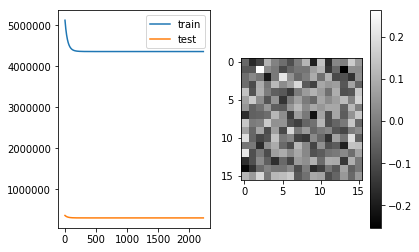

In [57]:
tikho = get_tikhonov(1)
clf = Lineaire(tikho, mse_g, eps=.0001, max_iter=0)
tr_x, tr_y = filter_classes(x_train, y_train, classes[0], classes[1])
te_x, te_y = filter_classes(x_test,  y_test,  classes[0], classes[1])
train_h, test_h = clf.fit(tr_x, (tr_y * 2 - 1), te_x, (te_y * 2 - 1))

plt.figure()
plt.subplot(121)
plt.plot(range(len(train_h)), train_h, label="train")
plt.plot(range(len(test_h)), test_h, label="test")
plt.legend()

plt.subplot(122)
plt.imshow(clf.w.reshape(16, 16), cmap="gray")
plt.colorbar()

print("Accuracy : ", (clf.predict(te_x) == te_y).mean())

Accuracy :  0.19696969696969696


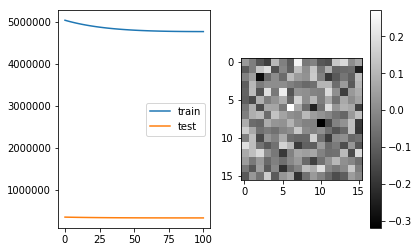

In [58]:
lasso = get_lasso(1)
clf = Lineaire(lasso, mse_g, eps=.0001, max_iter=0)
tr_x, tr_y = filter_classes(x_train, y_train, classes[0], classes[1])
te_x, te_y = filter_classes(x_test,  y_test,  classes[0], classes[1])
train_h, test_h = clf.fit(tr_x, (tr_y * 2 - 1), te_x, (te_y * 2 - 1))

plt.figure()
plt.subplot(121)
plt.plot(range(len(train_h)), train_h, label="train")
plt.plot(range(len(test_h)), test_h, label="test")
plt.legend()

plt.subplot(122)
plt.imshow(clf.w.reshape(16, 16), cmap="gray")
plt.colorbar()

print("Accuracy : ", (clf.predict(te_x) == te_y).mean())

Accuracy :  0.20833333333333334


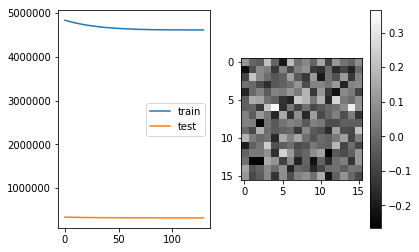

In [59]:
lasso = get_lasso(0.5)
clf = Lineaire(lasso, mse_g, eps=.0001, max_iter=0)
tr_x, tr_y = filter_classes(x_train, y_train, classes[0], classes[1])
te_x, te_y = filter_classes(x_test,  y_test,  classes[0], classes[1])
train_h, test_h = clf.fit(tr_x, (tr_y * 2 - 1), te_x, (te_y * 2 - 1))

plt.figure()
plt.subplot(121)
plt.plot(range(len(train_h)), train_h, label="train")
plt.plot(range(len(test_h)), test_h, label="test")
plt.legend()

plt.subplot(122)
plt.imshow(clf.w.reshape(16, 16), cmap="gray")
plt.colorbar()

print("Accuracy : ", (clf.predict(te_x) == te_y).mean())

Accuracy :  0.1875


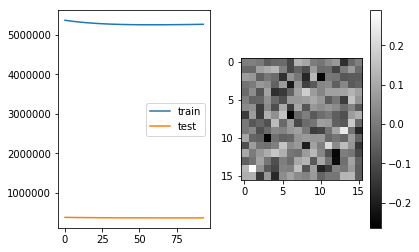

In [60]:
lasso = get_lasso(5)
clf = Lineaire(lasso, mse_g, eps=.0001, max_iter=0)
tr_x, tr_y = filter_classes(x_train, y_train, classes[0], classes[1])
te_x, te_y = filter_classes(x_test,  y_test,  classes[0], classes[1])
train_h, test_h = clf.fit(tr_x, (tr_y * 2 - 1), te_x, (te_y * 2 - 1))

plt.figure()
plt.subplot(121)
plt.plot(range(len(train_h)), train_h, label="train")
plt.plot(range(len(test_h)), test_h, label="test")
plt.legend()

plt.subplot(122)
plt.imshow(clf.w.reshape(16, 16), cmap="gray")
plt.colorbar()

print("Accuracy : ", (clf.predict(te_x) == te_y).mean())